In [45]:
from exactextract import exact_extract
import geopandas as gpd
import pandas as pd
from tqdm import tqdm
import numpy as np
from shapely.geometry import Polygon

import os
import glob
import pathlib
from multiprocess import Pool
from typing import Union, List, Any
import itertools
import math

In [55]:

def _chunks(data: gpd.GeoDataFrame, n: int, raster: str, stats: List[str], include_cols: List[str]) -> List[Any]:
    """Yield successive n-sized chunks from a slice-able iterable."""
    for i in range(0, len(data), n):
        yield [data[i:i + n], raster, stats, include_cols]    

def _zonal_stats_partial(feats: gpd.GeoDataFrame, raster: str, stats: List[str], include_cols: List[str]) -> List[Any]:
    from exactextract import exact_extract
    """Wrapper for zonal stats, takes a geodataframe"""
    return exact_extract(vec=feats, rast=raster, ops=stats, include_cols=include_cols, output="pandas")

def calculate_stats_parallel(polygon_layer_gdf: gpd.GeoDataFrame, raster: str, stats: List[str], pool: Pool, include_cols=['id'], n_jobs=16, index_column: str='id', prefix: str=''):
    """
    Calculate zonal statistics for a raster and a GeoDataFrame of polygons" in parallel.

    Args:
        polygon_layer_gdf (gpd.GeoDataFrame): A GeoDataFrame of polygons.
        raster (str): The path to the raster file.
        stats (List[str]): A list of statistics to calculate.
        pool (Pool): Pool of a jobs in multiprocess library.
        include_cols (List[str], optional): A list of columns to include in the output. Defaults to ['id'].
        n_jobs (int, optional): The number of cores to use for parallel processing. Defaults to 16.
        index_column (str, optional): The name of the index column. Defaults to 'id'.
        prefix (str, optional): A prefix string to add to the column names. Defaults to ''.

    Returns:
        pd.DataFrame: A DataFrame of zonal statistics.
    """
    # Define the number of cores to use for parallel processing
    
    # Use starmap and chunks for parallel processing
    stats_list = pool.starmap(_zonal_stats_partial,
                            _chunks(polygon_layer_gdf, round(len(polygon_layer_gdf) / pool._processes),
                                    raster,  stats, include_cols))
    stats_list = [df.set_index(index_column) for df in stats_list]
    calculated_stats = pd.concat(stats_list)
    
    if index_column is not None and index_column in include_cols:
        # change index dtype to dtype of index column in input layer
        index_dtype = str(polygon_layer_gdf[index_column].dtype)
        calculated_stats = calculated_stats.reset_index().astype({index_column:index_dtype})
        
    if len(prefix) > 0:
        # rename columns to include prefix string
        rename_dict = {stat: f"{prefix}{stat}" for stat in stats}
        calculated_stats = calculated_stats.rename(columns=rename_dict)
    
    return calculated_stats
    



In [78]:
n_jobs = 16
pool = Pool(n_jobs)
id_column = 'id'
stats = ['max', 'mean', 'variance', 'stdev']

# Paths to data
polygon_layer_path = r"E:\Praca\MGGP_Aero\Test_DATA\zbiorowiska_part.gpkg"
lidar_rasters_leafon_path = r'e:\Praca\MGGP_Aero\Test_DATA'

In [79]:
# list rasters of lidar metrics
lidar_rasters_leafon_pathlib = pathlib.Path(lidar_rasters_leafon_path)
lidar_rasters_list = list(lidar_rasters_leafon_pathlib.rglob("*.tif"))

In [80]:
polygon_layer_gdf = gpd.read_file(polygon_layer_path, engine="pyogrio")
polygon_layer_gdf = polygon_layer_gdf.reset_index().rename(columns={"index":"id"}).astype({'id':'int32'})

### Calculate metrics from a lidar rasters

In [89]:
polygon_layer_stats_gdf = polygon_layer_gdf.copy(deep=True)
for lidar_raster in tqdm(lidar_rasters_list):
    raster_name = lidar_raster.stem
    raster_rio = lidar_raster
    
    calculated_stats = calculate_stats_parallel(polygon_layer_gdf=polygon_layer_gdf, raster=lidar_raster,
                                            stats=stats, pool=pool, include_cols=[id_column], index_column=id_column, 
                                            n_jobs=n_jobs, prefix=f'{raster_name}_')
    polygon_layer_stats_gdf = pd.merge(polygon_layer_stats_gdf, calculated_stats, on='id', how='left')
    

100%|██████████| 1/1 [00:19<00:00, 19.35s/it]

19.3 s ± 509 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
polygon_layer_stats_gdf

,id,NazwSkro,geometry,p341_gat_ekspansywne_raw_max,p341_gat_ekspansywne_raw_mean,p341_gat_ekspansywne_raw_variance,p341_gat_ekspansywne_raw_stdev
0,0,Galio-Urticenea,"MULTIPOLYGON (((5486151.000 5833604.000, 54861...",7.0,6.076389,5.612220,2.369013
1,1,Galio-Urticenea,"MULTIPOLYGON (((5486281.000 5833627.000, 54862...",7.0,4.816000,10.518144,3.243169
2,2,Galio-Urticenea,"MULTIPOLYGON (((5486240.000 5833627.000, 54862...",7.0,2.962121,8.081899,2.842868
3,3,Galio-Urticenea,"MULTIPOLYGON (((5486242.000 5833597.000, 54862...",7.0,4.590062,10.051413,3.170396
4,4,Galio-Urticenea,"MULTIPOLYGON (((5486298.000 5833620.000, 54862...",7.0,4.293334,11.620623,3.408903
...,...,...,...,...,...,...,...
20453,20453,Phragmitetum australis,"MULTIPOLYGON (((5486474.000 5830515.000, 54864...",6.0,5.977986,0.110878,0.332984
20454,20454,Phragmitetum australis,"MULTIPOLYGON (((5487277.000 5830490.000, 54872...",7.0,5.109756,6.239986,2.497996
20455,20455,Molinietalia-pozostale,"MULTIPOLYGON (((5487852.000 5830483.000, 54878...",5.0,0.170157,0.821832,0.906549
20456,20456,Phalaridetum arundinaceae,"MULTIPOLYGON (((5487822.000 5830482.000, 54878...",5.0,4.985417,0.056037,0.236722


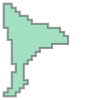

In [25]:
polygon_layer_stats_gdf.iloc[0].geometry

### Calculate other metrics

In [15]:
polygon_layer_stats_gdf['crownArea'] = polygon_layer_stats_gdf.geometry.area

In [19]:
# Define a function to calculate diameter
def calculate_diameter(area):
    return 2 * (math.sqrt(area / math.pi))

polygon_layer_stats_gdf['crown_diameter'] = polygon_layer_stats_gdf['crownArea'].apply(calculate_diameter)

In [25]:
polygon_layer_stats_gdf['crown_diameter_ln'] = np.log(polygon_layer_stats_gdf['crown_diameter'])
polygon_layer_stats_gdf['crownArea_ln'] = np.log(polygon_layer_stats_gdf['crownArea'])

In [9]:
polygon_layer_stats_gdf.columns

Index(['gid', 'id', 'treeID', 'crownArea', 'layer', 'path', 'geometry',
       'FHD_max', 'FHD_mean', 'FHD_variance',
       ...
       'zq95_variance', 'zq95_stdev', 'zsd_max', 'zsd_mean', 'zsd_variance',
       'zsd_stdev', 'zskew_max', 'zskew_mean', 'zskew_variance',
       'zskew_stdev'],
      dtype='object', length=707)

### Save layer

In [27]:
polygon_layer_stats_gdf.to_file(r"../../../../Data/Wroclaw/Segmentacja/Segmenty_statystyki_LeafOn.gpkg", engine="pyogrio")

In [26]:
polygon_layer_stats_gdf.to_parquet(r"../../../../Data/Wroclaw/Segmentacja/Segmenty_statystyki_LeafOn.parquet")